## 1. 데이터 준비

In [1]:
%matplotlib inline
# Standard library imports
import datetime
from datetime import datetime
import os
from copy import deepcopy
import pickle

# Third-party libraries imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import seaborn as sns
import random
from itertools import combinations

# from IPython.display import clear_output
from scipy.spatial import distance
from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import datasets, transforms

# Local application/library specific imports
from data_utils import (generate_server_idcs, CustomSubset, split_3class_unbalanced, split_contain_multiclass,
                        split_7plus3class_unbalanced, CombinedCustomSubset)
from fl_devices import Server, Client
from helper import ExperimentLogger, display_train_stats
from models import ConvNet, Representation, Ten_class_classifier


torch.manual_seed(42)
np.random.seed(42)

In [2]:
LOCAL_EPOCHS = 25
N_CLIENTS = 6
NUMBER_OF_CLUSTER = 3
ALPHA = 0.1
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
#data = datasets.CIFAR10(root="CIFAR10/", download=True)
data = datasets.MNIST(root="MNIST/", download=False)
idcs = np.random.permutation(len(data))

def cluster(server, clients, number_of_cluster):
    label_predicted = pd.DataFrame()
    # label_acc = pd.DataFrame()
    for i, client in enumerate(clients):
        pred = server.check_cluster(client.model)
        # print(f'pred: {pred}')
        label_predicted = pd.concat([label_predicted, pd.DataFrame(pred, index=[i])])
        # label_acc = pd.concat([label_acc, pd.DataFrame(acc, index=[i])])
    label_predicted.reset_index(drop=True, inplace=True)
    label_predicted.fillna(0, inplace=True)
    
    print(f'predicted label')
    print(label_predicted)

    cluster_idcs, number_of_cluster= server.cluster_clients(label_predicted)
    return label_predicted, cluster_idcs, number_of_cluster



def get_cluster_averages(df, cluster_idcs):
    cluster_averages = {}

    for i, cluster in enumerate(cluster_idcs):
        cluster_data = df.loc[cluster, :]
        cluster_average = cluster_data.mean()
        cluster_averages[i] = cluster_average

    cluster_averages_df = pd.DataFrame(cluster_averages).T

    # calculate percentage for each value in a row
    cluster_percentages_df = cluster_averages_df.div(cluster_averages_df.sum(axis=1), axis=0).multiply(100)

    # apply threshold and rounding
    cluster_percentages_df = cluster_percentages_df.where(cluster_percentages_df >= 5, 0).round()

    return cluster_percentages_df / 10


def get_cluster_weights(cluster_logits, cluster_weight_per_class):
    # Step 1: Find the class with the maximum value in each logit in cluster_logits
    # Assuming the dimension for classes is the second one
    max_classes = [torch.argmax(logit, dim=1) for logit in cluster_logits]
    
    print(max_classes)
    cluster_weights = []
    #c luster별로 
    for i, iogits in enumerate(cluster_logits):
        weights = []
        for j, logit in enumerate(logits):
            
            # print(f'max_classes: {max_classes[i][j]}')
            # print("Shape of cluster_weight_per_class[{}]: ".format(i), cluster_weight_per_class[i].shape)
            weights.append(max_classes[i][j])
        print(weights)
        cluster_weights.append(weights)

def visualize_clusters(label_predicted, real_cluster_distribution):
    # Reduce the dimension of the data
    pca = PCA(n_components=2)
    label_predicted_pca = pca.fit_transform(label_predicted)
    
    # Define colors for the clusters
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # Calculate the number of samples in each real cluster
    n_samples = len(label_predicted)
    real_cluster_sizes = [int(n_samples * dist) for dist in real_cluster_distribution]

    # Plot the clusters
    plt.figure(figsize=(8, 5))

    start_idx = 0  # To keep track of the start index of each real cluster
    for i, size in enumerate(real_cluster_sizes):
        end_idx = start_idx + size  # Calculate the end index for this real cluster
        color = colors[i % len(colors)]  # Determine the color for this real cluster

        # Scatter plot for points belonging to this real cluster
        for j in range(start_idx, end_idx):
            plt.scatter(label_predicted_pca[j, 0], label_predicted_pca[j, 1], c=color, s=50, label=f'Group {i+1}' if j == start_idx else "")

        start_idx = end_idx  # Update the start index for the next real cluster
    
    # Remove duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize='xx-large')

    # Remove x and y ticks
    plt.xticks([])
    plt.yticks([])

    # Save the figure with narrow margins
    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
    current_time = datetime.now().strftime('%Y%m%d%H%M%S')
    plt.savefig(f'Figures/cluster_visualization_{current_time}.png', dpi=300, format='png')

    
    plt.show()



#     # Print the real cluster distribution
#     print("Real cluster distribution:", real_cluster_distribution)

#     # Calculate and print each client's cluster identity based on the real_cluster_distribution
#     n_clients = len(label_predicted)
#     cumulative_distribution = [0] + [sum(real_cluster_distribution[:i+1]) for i in range(len(real_cluster_distribution))]
#     client_cluster_id_real = [next((i for i, val in enumerate(cumulative_distribution) if val > client_idx / n_clients), -1) - 1 for client_idx in range(n_clients)]

#     print("Real cluster identity for each client:", client_cluster_id_real)

#     # Print each client's cluster identity based on the clusters argument
#     client_cluster_id_predicted = [next((i for i, cluster in enumerate(clusters) if client_idx in cluster), -1) for client_idx in range(n_clients)]
#     print("Predicted cluster identity for each client:", client_cluster_id_predicted)




def test_acc(server, clients, cluster_distribution):
    
    # Get individual client accuracies
    acc_clients = [client.evaluate() for client in clients]

    # Compute the average accuracy for each client
    client_acc = round(sum(acc_clients) / len(acc_clients), 3) if len(acc_clients) > 0 else 0

    # Compute cluster accuracies for this iteration
    cluster_accs_iteration = []
    start_idx = 0
    for distribution in cluster_distribution:
        end_idx = start_idx + int(distribution * len(clients))
        cluster_acc = round(sum(acc_clients[start_idx:end_idx]) / (end_idx - start_idx) + 0.000001, 3)
        cluster_accs_iteration.append(cluster_acc)
        start_idx = end_idx

    # Compute global accuracy for this iteration
    accuracies = [server.evaluate_distil(client.classifier) for client in clients]
    global_acc = round(np.mean(accuracies), 3)
    
    return client_acc, cluster_accs_iteration, global_acc


def get_global_logits(client_logits):
    avg_logits = torch.mean(torch.stack(client_logits), dim=0)
    return avg_logits

# def get_cluster_logits(client_logits, cluster_idcs):
#     cluster_logits = []
#     for i, cluster in enumerate(cluster_idcs):
#         cluster_client_logits = [client_logits[i] for i in cluster]
#         avg_cluster_logits = torch.mean(torch.stack(cluster_client_logits), dim=0)
#         cluster_logits.append(avg_cluster_logits)
#     return cluster_logits


def get_cluster_averages(df, cluster_idcs):
    cluster_averages = {}

    for i, cluster in enumerate(cluster_idcs):
        cluster_data = df.loc[cluster, :]
        cluster_average = cluster_data.mean()
        cluster_averages[i] = cluster_average

    cluster_averages_df = pd.DataFrame(cluster_averages).T

    # calculate percentage for each value in a row
    cluster_percentages_df = cluster_averages_df.div(cluster_averages_df.sum(axis=1), axis=0).multiply(100)

    # apply threshold and rounding
    cluster_percentages_df = cluster_percentages_df.where(cluster_percentages_df >= 5, 0).round()

    return cluster_percentages_df / 10

def compute_accuracy(global_logits, data_targets, server_idcs):
    """
    Compute accuracy of predictions based on global logits.

    Args:
    - global_logits (list of Tensors): Each Tensor represents the logits for a data instance, 
                                       and its size is the number of classes.
    - data_targets (list of ints): List of true labels for all data.
    - server_idcs (list of ints): Indices of data instances we're interested in.

    Returns:
    - accuracy (float): Computed accuracy.
    """
    true_labels = [data_targets[i] for i in server_idcs]
    
    correct_predictions = 0
    total_predictions = len(true_labels)

    for logits, label in zip(global_logits, true_labels):
        predicted_label = np.argmax(logits.cpu().numpy())  # Convert Tensor to numpy and get index of max value
        if predicted_label == label:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy


def save_tensor_to_csv(tensor, filename):
    # Convert tensor to numpy array
    array = tensor.cpu().detach().numpy()
    
    # Save numpy array to CSV file
    np.savetxt(filename, array, delimiter=",")

# def get_cluster_weights(cluster_logits, cluster_weight_per_class):
#     # Step 1: Find the class with the maximum value in each logit in cluster_logits
#     # Assuming the dimension for classes is the second one
#     max_classes = [torch.argmax(logit, dim=1) for logit in cluster_logits]
    
#     print(max_classes)
#     cluster_weights = []
#     #c luster별로 
#     for i, iogits in enumerate(cluster_logits):
#         weights = []
#         for j, logit in enumerate(logits):
            
#             # print(f'max_classes: {max_classes[i][j]}')
#             # print("Shape of cluster_weight_per_class[{}]: ".format(i), cluster_weight_per_class[i].shape)
#             weights.append(max_classes[i][j])
#         print(weights)
#         cluster_weights.append(weights)


### DS-FL

In [4]:
import torch
import torch.nn.functional as F
from scipy.special import kl_div

# Step 3: Apply softmax to get probability distribution
def apply_softmax(logits):
    return F.softmax(logits, dim=-1)

# Step 4: Average probability distributions
def average_prob_distributions(prob_distributions):
    return torch.mean(torch.stack(prob_distributions), dim=0)

# Step 5: Apply ERA technique to reduce entropy
def kl_divergence(p, q):
    return torch.sum(p * torch.log(p / q), dim=-1, keepdim=True)


def apply_ERA(avg_prob_distributions, local_prob_distributions, temperature=0.1):
    # Calculate reference distribution
    reference_distribution = apply_softmax(torch.mean(torch.stack(local_prob_distributions), dim=0))

    # Minimize KL divergence to reduce entropy, scaled by temperature
    kl_term = kl_divergence(avg_prob_distributions, reference_distribution)
    reduced_entropy_logits = avg_prob_distributions - temperature * kl_term

    return reduced_entropy_logits

# Step 1, 2, 3, 4, 5: Replace your existing function
def get_global_logits_DS_FL(client_logits, temperature=0.1):
    # Step 3: Apply softmax to each local logit
    client_prob_distributions = [apply_softmax(logits) for logits in client_logits]

    # Step 4: Average the probability distributions
    avg_prob_distributions = average_prob_distributions(client_prob_distributions)

    # Step 5: Apply ERA to the averaged logits
    reduced_entropy_logits = apply_ERA(avg_prob_distributions, client_prob_distributions, temperature)

    return reduced_entropy_logits.detach()

In [5]:
def make_global_logit(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instance_per_minor_class, instances_per_class_per_client):
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))
    print(f'sever idcs: {len(server_idcs)}')
    #client_idcs, _ = split_7plus3class_unbalanced(train_idcs, train_labels, n_clients, cluster_distribution, instance_per_class, instance_per_minor_class)
    client_idcs = split_contain_multiclass(train_idcs, train_labels, n_clients, instance_per_class, instances_per_class_per_client, cluster_distribution)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))
    print(f'test_data: {len(test_data)}')
    
    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.Adam(x),test_data)

    clients = [Client(Representation, dat, i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    
    # print(f'client count: {len(clients)}')

    client_logits = []
    
        
    # 1. Train classifier
    for i, client in enumerate(clients):
        client.classifier = Ten_class_classifier(client.model).to(device)
        client.train_classifier(lr=1e-3)

    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    # 2. get client loigt
    for i, client in enumerate(clients):
        client_logits.append(server.get_clients_logit(client.classifier))

    # 3. make global logit
    global_logits = server.get_global_logits(client_logits)
    accuracy = compute_accuracy(global_logits, test_labels, server_idcs)
    
    print(f"Global Logit's Accuracy: {accuracy * 100:.2f}%")
    
    return server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, client_acc, cluster_accs, global_acc

def distill_with_cluster_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, t):
    cluster_logits,  cluster_idcs, label_predicted = server.get_cluster_logits(client_logits, number_of_cluster, t)
    visualize_clusters(label_predicted, cluster_distribution)
    silhouette, ari = server.evaluate_clustering(label_predicted, cluster_distribution, cluster_idcs)
    
    print(f'silhouette: {silhouette}, ari: {ari}')

    cluster_distill_loaders = []
    
    for cluster_logit in cluster_logits:
        distill_loader = server.create_distill_loader(data, server_idcs, cluster_logit)
        cluster_distill_loaders.append(distill_loader)
        
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        
        cluster_idx = next(j for j, cluster in enumerate(cluster_idcs) if i in cluster)
        
        client.distill((cluster_distill_loaders[cluster_idx]))
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc, silhouette, ari


def get_cluster_acc(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, t):
    cluster_logits,  cluster_idcs, label_predicted = server.get_cluster_logits(client_logits, number_of_cluster, t)
    visualize_clusters(label_predicted, cluster_distribution)
    silhouette, ari = server.evaluate_clustering(label_predicted, cluster_distribution, cluster_idcs)
    
    print(f'silhouette: {silhouette}, ari: {ari}')
    return silhouette, ari


def FedDF(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution):
    distill_loader = server.create_distill_loader(data, server_idcs, global_logits)
    
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        client.distill(distill_loader)
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc


def DS_FL(server, clients, client_logits, number_of_cluster, server_idcs, cluster_distribution):
    global_logits = get_global_logits_DS_FL(client_logits)

    distill_loader = server.create_distill_loader(data, server_idcs, global_logits)
    
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        client.distill(distill_loader)
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc


def copy_classifiers(clients):
    classifiers_state = []
    for client in clients:
        classifier_state = client.classifier.state_dict()
        classifiers_state.append(classifier_state)
    return classifiers_state


In [6]:
def cluster_train_result_exp(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instance_per_minor_class, instances_per_class_per_client, t):
   
    client_accs = []
    cluster_accs = []
    global_accs = []
    
    (
        server, clients, client_logits, global_logits,
        number_of_cluster, server_idcs, cluster_distribution,
        new_client_acc, new_cluster_accs, new_global_acc
    ) = make_global_logit(
        n_clients, total_client_data, distill_data,
        number_of_cluster, cluster_distribution,
        instance_per_class, instance_per_minor_class, instances_per_class_per_client
    )

    
    print(f'acc before distill: {new_client_acc}, {new_cluster_accs}, {new_global_acc}')
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)

    classifiers_state = copy_classifiers(clients)
    
    new_client_acc, new_cluster_accs, new_global_acc, silhouette, ari = distill_with_cluster_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, t)
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)
    
    for i, client in enumerate(clients):
        client.classifier.load_state_dict(classifiers_state[i])
    
    new_client_acc, new_cluster_accs, new_global_acc = FedDF(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution)
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)
    
    
    for i, client in enumerate(clients):
        client.classifier.load_state_dict(classifiers_state[i])
    
    new_client_acc, new_cluster_accs, new_global_acc = DS_FL(server, clients, client_logits, number_of_cluster, server_idcs, cluster_distribution)
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)
    
    print(f'Ours: {client_accs[-3]}, {cluster_accs[-3]}, {global_accs[-3]}')
    print(f'FedDF: {client_accs[-2]}, {cluster_accs[-2]}, {global_accs[-2]}')
    print(f'DS_FL: {client_accs[-1]}, {cluster_accs[-1]}, {global_accs[-1]}')
    return client_accs, cluster_accs, global_accs, silhouette, ari

def clustering_exp(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instance_per_minor_class, instances_per_class_per_client, t):
   
    client_accs = []
    cluster_accs = []
    global_accs = []
    
    (
        server, clients, client_logits, global_logits,
        number_of_cluster, server_idcs, cluster_distribution,
        new_client_acc, new_cluster_accs, new_global_acc
    ) = make_global_logit(
        n_clients, total_client_data, distill_data,
        number_of_cluster, cluster_distribution,
        instance_per_class, instance_per_minor_class, instances_per_class_per_client
    )

    
    print(f'acc before distill: {new_client_acc}, {new_cluster_accs}, {new_global_acc}')
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)

    classifiers_state = copy_classifiers(clients)
    
    sil, ari = get_cluster_acc(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, t)
    return sil, ari


def get_combination(array_length, class_per_cluster):
    if class_per_cluster == 1:
        combinations = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
    elif class_per_cluster == 2:
        combinations = [[0,1], [2,3], [4,5], [6,7], [8,9], [0,5], [1,6], [2,7], [3,8], [4,9], [0,3], [1,4], [2,5], [6,8], [7,9], [0,4], [1,5], [2,9], [3,7], [8,6]]
    elif class_per_cluster == 3:
        combinations = [[0,1,2], [3,4,5], [6,7,8], [9,0,1], [2,3,4], [5,6,7], [8,9,0], [1,2,3], [4,5,6], [7,8,9]]
    elif class_per_cluster == 4:
        combinations = [[0,1,2,3],[4,5,6,7],[8,9,0,1],[2,3,4,5],[6,7,8,9],[2,4,6,8],[1,3,5,9],[0,3,6,9],[1,4,7,0],[2,5,8,1]]
    elif class_per_cluster == 5:
        combinations = [[0,1,2,3,4],[4,5,6,7,8],[8,9,0,1,2],[2,3,4,5,6],[6,7,8,9,0],[2,4,6,8,0],[1,3,5,7,9],[0,2,3,6,9],[1,4,6,7,0],[2,5,6,8,1]]
    else:
        return "Invalid class_per_cluster"
    
    return combinations[:array_length]


In [7]:
def model_clustering_exp(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instances_per_class_per_client):
    print(f'number_of_cluster: {number_of_cluster}')
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))

    # client_idcs = split_noniid(train_idcs, train_labels, alpha=alpha, n_clients=N_CLIENTS)
    client_idcs = split_contain_multiclass(train_idcs, train_labels, n_clients, instance_per_class, instances_per_class_per_client)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(Representation, lambda x : torch.optim.Adam(x),test_data)

    clients = [Client(Representation, dat, i) for i, dat in enumerate(client_data) if len(dat) > 20]
    

    # 1. Train classifier
    for i, client in enumerate(clients):
        client.train_classifier(lr=1e-3)

    similarities = server.compute_pairwise_similarities(clients)
    # print('similarities')
    # print(type(similarities))
    # print(similarities)
    cluster_idcs = server.cluster_clients_KMeans(similarities, number_of_cluster)
    
    visualize_clusters(similarities, cluster_distribution)
    silhouette, ari = server.evaluate_clustering(similarities, cluster_distribution, cluster_idcs)
    print(f'silhouette: {silhouette}, ari: {ari}')
    return silhouette, ari

### Performance Exp

sever idcs: 100
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 100
Global Logit's Accuracy: 30.00%
acc before distill: 0.96, [0.973, 0.92, 0.987], 0.183
[0 0 0 0 0 2 2 2 2 2 1 1 1 1 1]


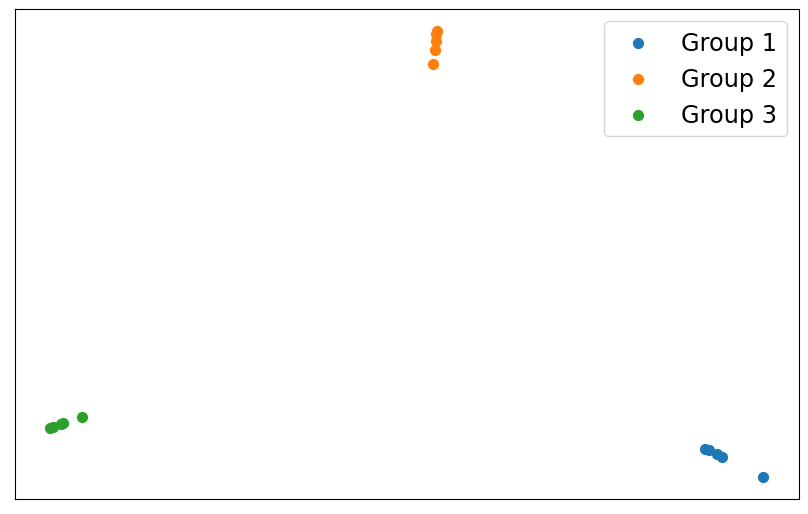

15
predicted_labels: [0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8451271653175354, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.973, [0.987, 0.947, 0.987], 0.185
FedDF: 0.609, [0.84, 0.493, 0.493], 0.247
DS_FL: 0.591, [0.933, 0.453, 0.387], 0.311
sever idcs: 100
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 100
Global Logit's Accuracy: 65.00%
acc before distill: 0.884, [0.973, 0.773, 0.907], 0.257
[1 1 1 1 1 2 2 2 2 2 0 0 0 0 0]


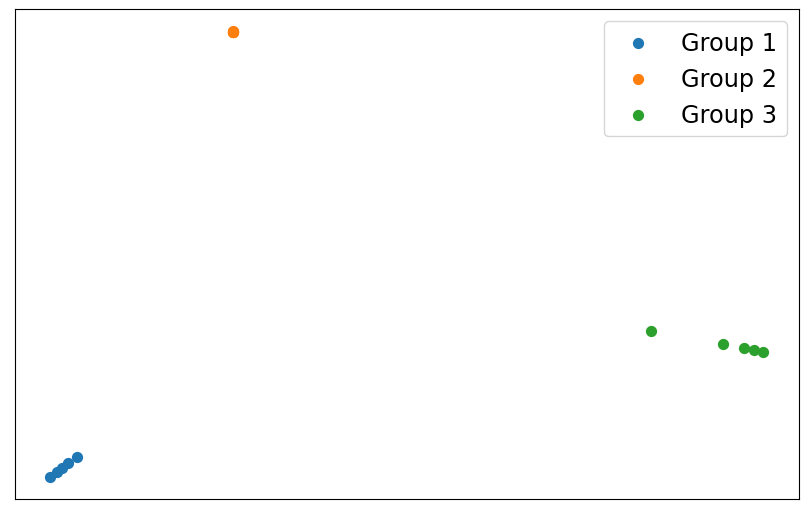

15
predicted_labels: [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.7884047627449036, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.92, [0.987, 0.867, 0.907], 0.267
FedDF: 0.618, [0.747, 0.413, 0.693], 0.361
DS_FL: 0.671, [0.813, 0.52, 0.68], 0.648
sever idcs: 100
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 100
Global Logit's Accuracy: 56.00%
acc before distill: 0.876, [0.907, 0.893, 0.827], 0.353
[2 2 2 2 2 1 1 1 1 1 0 0 0 0 0]


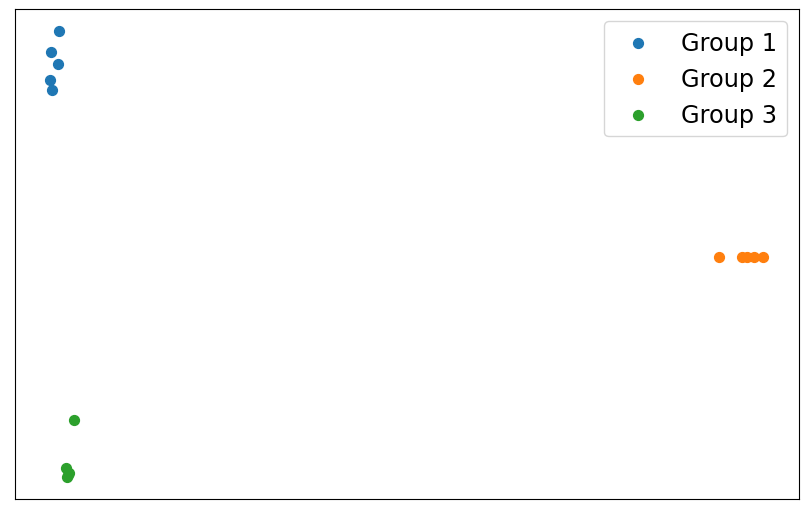

15
predicted_labels: [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8158994913101196, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.898, [0.88, 0.947, 0.867], 0.374
FedDF: 0.556, [0.667, 0.267, 0.733], 0.384
DS_FL: 0.64, [0.787, 0.347, 0.787], 0.595
sever idcs: 100
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 100
Global Logit's Accuracy: 58.00%
acc before distill: 0.818, [0.933, 0.747, 0.773], 0.411
[2 2 2 2 2 0 0 0 0 0 1 1 1 1 1]


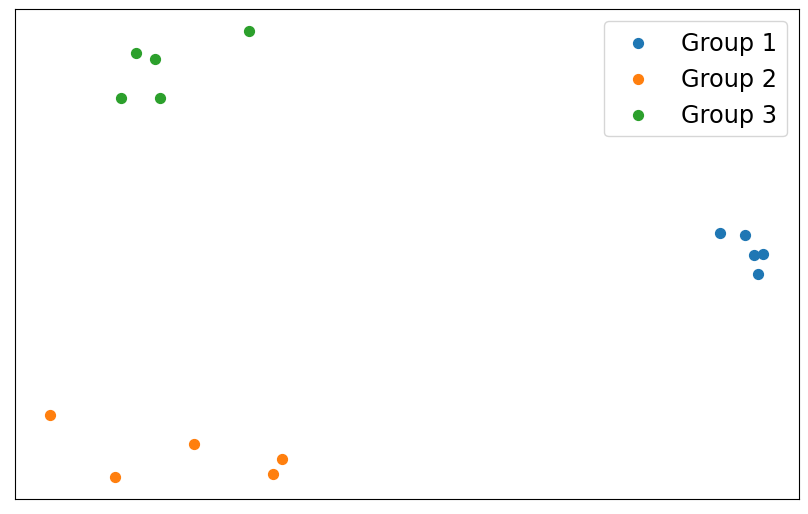

15
predicted_labels: [2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.6801204085350037, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.853, [0.96, 0.813, 0.787], 0.457
FedDF: 0.556, [0.68, 0.44, 0.547], 0.419
DS_FL: 0.671, [0.827, 0.507, 0.68], 0.577
sever idcs: 300
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 300
Global Logit's Accuracy: 32.33%
acc before distill: 0.902, [0.987, 0.827, 0.893], 0.299
[1 1 1 1 1 2 2 2 2 2 0 0 0 0 0]


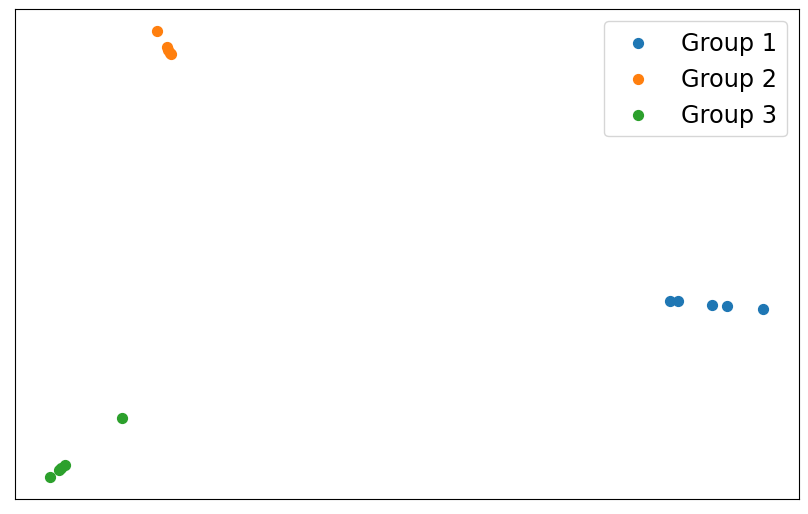

15
predicted_labels: [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.6414116024971008, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.964, [0.987, 0.92, 0.987], 0.308
FedDF: 0.547, [0.96, 0.28, 0.4], 0.606
DS_FL: 0.547, [0.973, 0.333, 0.333], 0.626
sever idcs: 300
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 300
Global Logit's Accuracy: 63.67%
acc before distill: 0.88, [0.973, 0.773, 0.893], 0.304
[2 2 2 2 2 1 1 1 1 1 0 0 0 0 0]


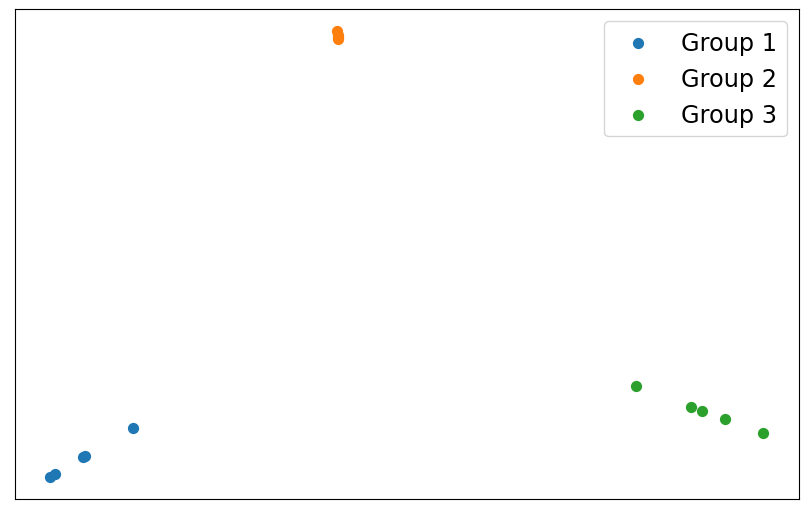

15
predicted_labels: [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.7492951154708862, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.924, [0.987, 0.84, 0.947], 0.317
FedDF: 0.609, [0.613, 0.547, 0.667], 0.56
DS_FL: 0.649, [0.693, 0.52, 0.733], 0.699
sever idcs: 300
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 300
Global Logit's Accuracy: 52.00%
acc before distill: 0.88, [0.92, 0.84, 0.88], 0.441
[2 2 2 2 2 0 0 0 0 0 1 1 1 1 1]


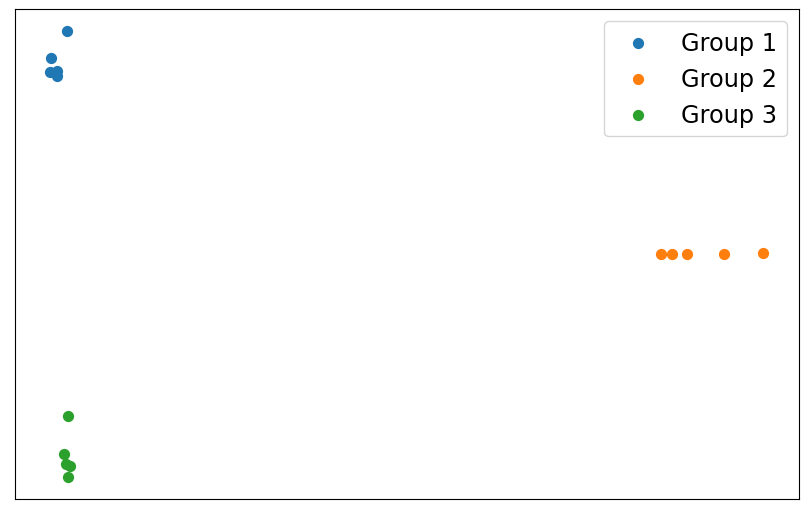

15
predicted_labels: [2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.7624868750572205, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.933, [0.933, 0.96, 0.907], 0.455
FedDF: 0.564, [0.733, 0.173, 0.787], 0.694
DS_FL: 0.609, [0.84, 0.187, 0.8], 0.761
sever idcs: 300
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 300
Global Logit's Accuracy: 58.00%
acc before distill: 0.791, [0.947, 0.72, 0.707], 0.492
[2 2 2 2 2 1 1 1 1 1 0 0 0 0 0]


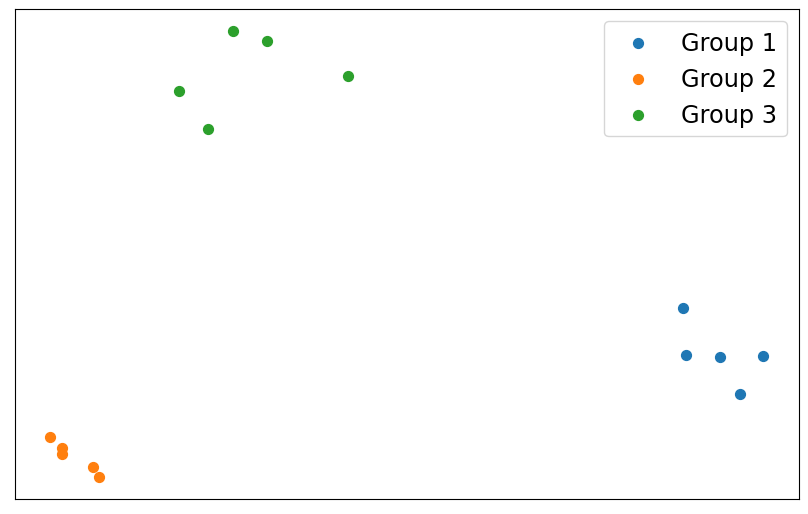

15
predicted_labels: [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.6681390404701233, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.84, [0.96, 0.827, 0.733], 0.514
FedDF: 0.644, [0.88, 0.44, 0.613], 0.731
DS_FL: 0.676, [0.893, 0.52, 0.613], 0.782
sever idcs: 500
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 500
Global Logit's Accuracy: 35.00%
acc before distill: 0.96, [0.96, 0.933, 0.987], 0.323
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]


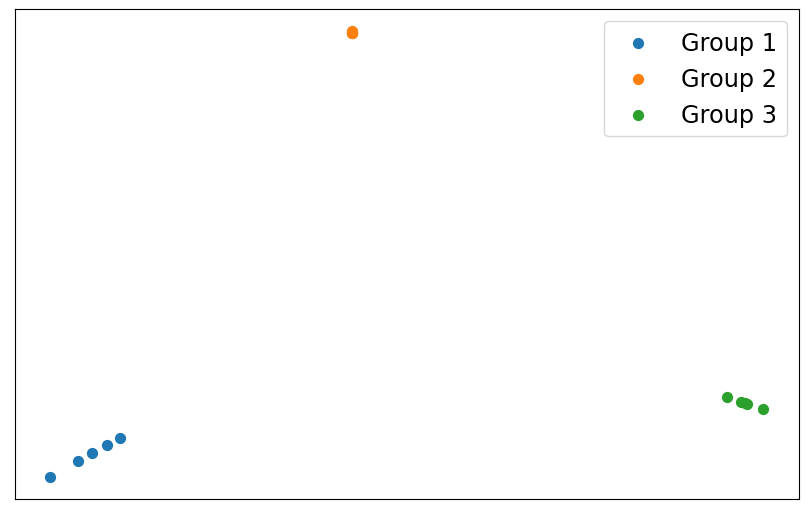

15
predicted_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8636342287063599, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.969, [0.987, 0.933, 0.987], 0.326
FedDF: 0.578, [0.84, 0.44, 0.453], 0.826
DS_FL: 0.573, [0.867, 0.333, 0.52], 0.871
sever idcs: 500
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 500
Global Logit's Accuracy: 58.80%
acc before distill: 0.902, [0.973, 0.773, 0.96], 0.316
[0 0 0 0 0 2 2 2 2 2 1 1 1 1 1]


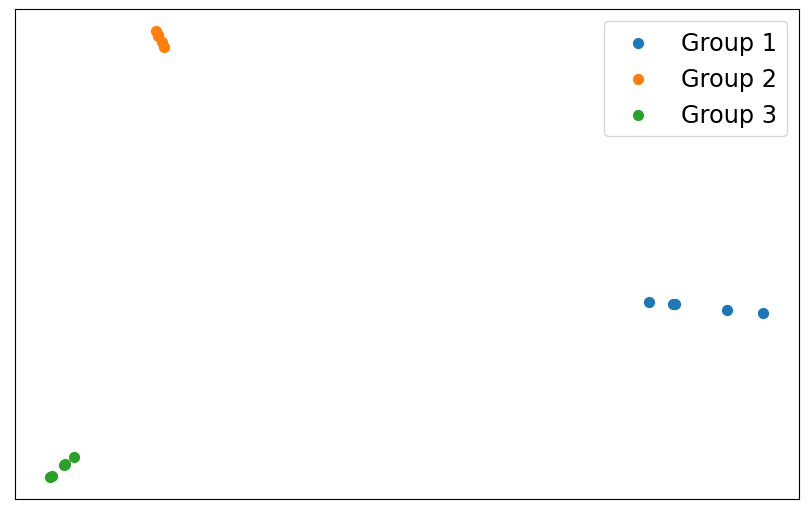

15
predicted_labels: [0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.7363836765289307, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.916, [0.987, 0.84, 0.92], 0.321
FedDF: 0.596, [0.813, 0.547, 0.427], 0.794
DS_FL: 0.636, [0.867, 0.573, 0.467], 0.811
sever idcs: 500
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 500
Global Logit's Accuracy: 51.20%
acc before distill: 0.884, [0.947, 0.893, 0.813], 0.549
[2 2 2 2 2 1 1 1 1 1 0 0 0 0 0]


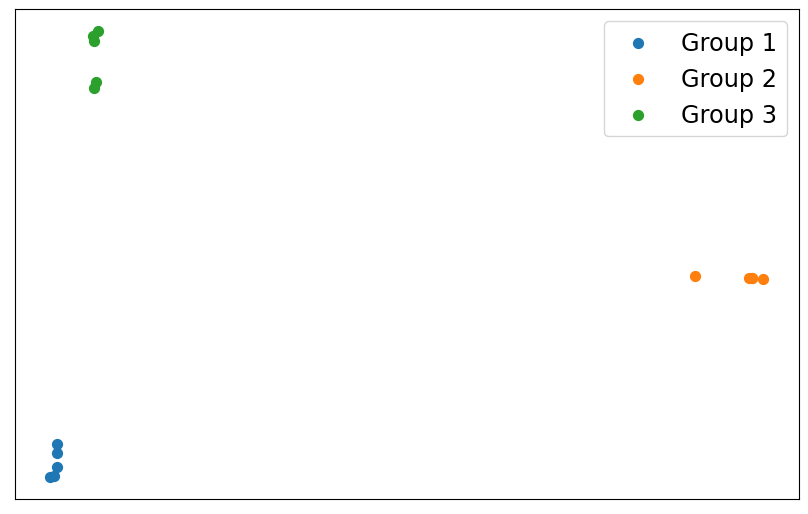

15
predicted_labels: [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8301042914390564, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.902, [0.92, 0.947, 0.84], 0.56
FedDF: 0.564, [0.827, 0.12, 0.747], 0.918
DS_FL: 0.587, [0.827, 0.16, 0.773], 0.929
sever idcs: 500
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 500
Global Logit's Accuracy: 60.20%
acc before distill: 0.84, [0.947, 0.787, 0.787], 0.58
[2 2 2 2 2 0 0 0 0 0 1 1 1 1 1]


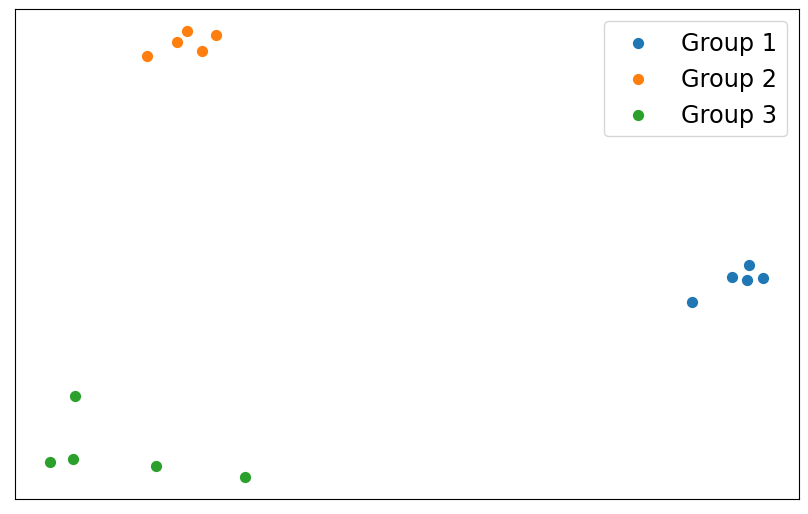

15
predicted_labels: [2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.7055321335792542, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.867, [0.96, 0.867, 0.773], 0.607
FedDF: 0.658, [0.853, 0.48, 0.64], 0.918
DS_FL: 0.707, [0.88, 0.587, 0.653], 0.923
sever idcs: 1000
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 1000
Global Logit's Accuracy: 36.50%
acc before distill: 0.924, [0.987, 0.92, 0.867], 0.327
[2 2 2 2 2 1 1 1 1 1 0 0 0 0 0]


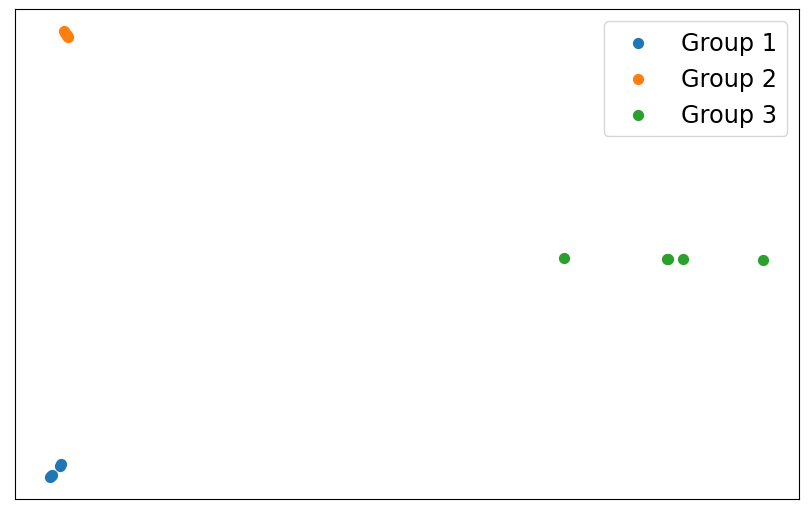

15
predicted_labels: [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8278144598007202, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.973, [0.973, 0.96, 0.987], 0.327
FedDF: 0.591, [0.867, 0.613, 0.293], 0.871
DS_FL: 0.582, [0.893, 0.587, 0.267], 0.911
sever idcs: 1000
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 1000
Global Logit's Accuracy: 60.50%
acc before distill: 0.884, [0.973, 0.773, 0.907], 0.314
[2 2 2 2 2 1 1 1 1 1 0 0 0 0 0]


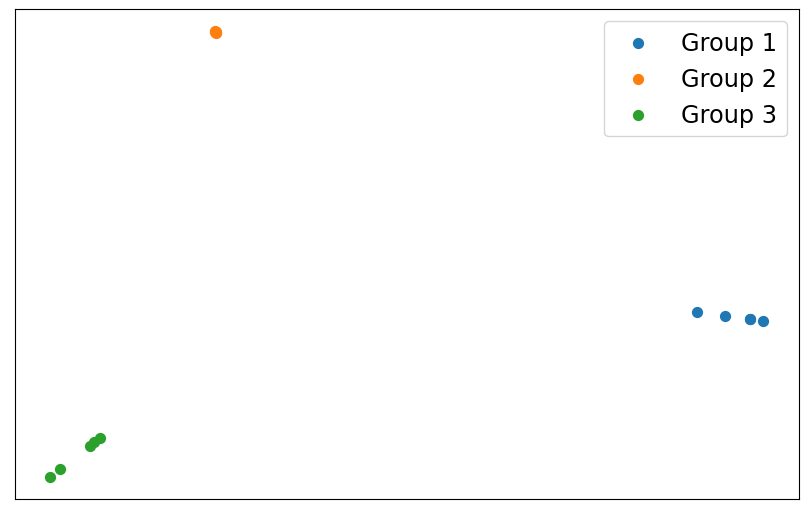

15
predicted_labels: [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.780896008014679, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.929, [0.987, 0.853, 0.947], 0.324
FedDF: 0.6, [0.84, 0.4, 0.56], 0.874
DS_FL: 0.649, [0.84, 0.453, 0.653], 0.884
sever idcs: 1000
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 1000
Global Logit's Accuracy: 59.00%
acc before distill: 0.853, [0.893, 0.84, 0.827], 0.55
[1 1 1 1 1 0 0 0 0 0 2 2 2 2 2]


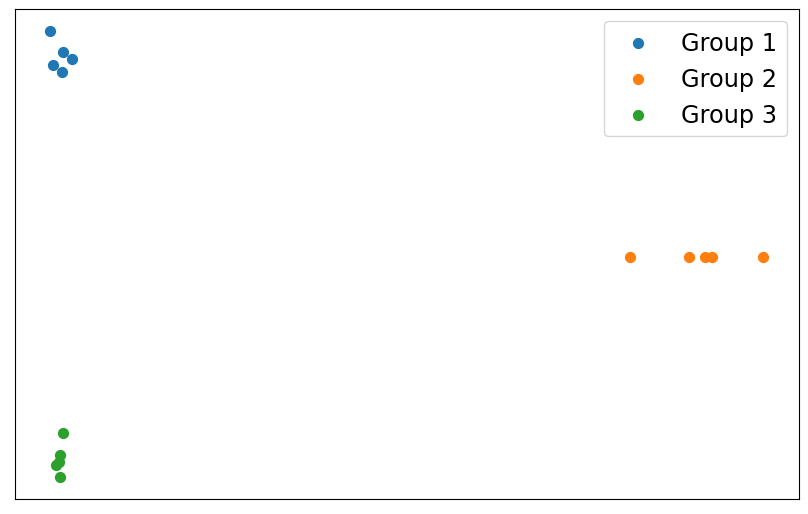

15
predicted_labels: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.7019072771072388, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.92, [0.933, 0.947, 0.88], 0.559
FedDF: 0.662, [0.72, 0.413, 0.853], 0.842
DS_FL: 0.662, [0.72, 0.413, 0.853], 0.856
sever idcs: 1000
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 1000
Global Logit's Accuracy: 56.70%
acc before distill: 0.858, [0.92, 0.827, 0.827], 0.586
[2 2 2 2 2 0 0 0 0 0 1 1 1 1 1]


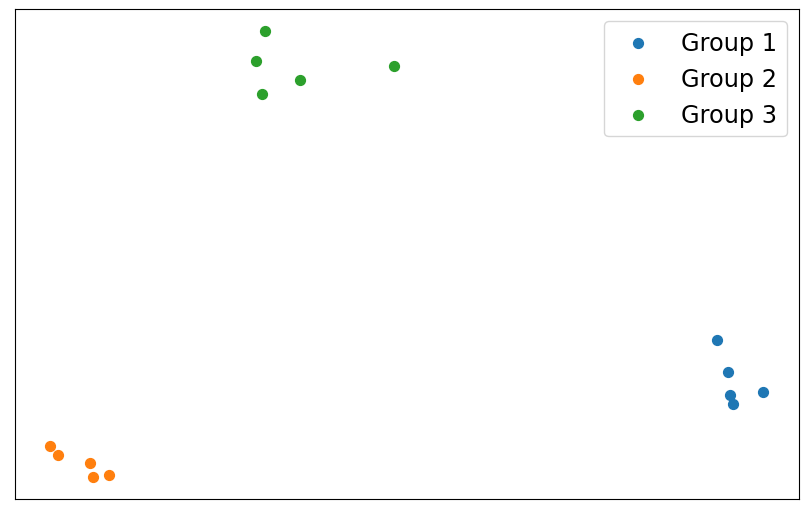

15
predicted_labels: [2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.7429522275924683, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.867, [0.947, 0.893, 0.76], 0.617
FedDF: 0.649, [0.84, 0.493, 0.613], 0.941
DS_FL: 0.684, [0.92, 0.533, 0.6], 0.94
sever idcs: 100
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 100
Global Logit's Accuracy: 37.00%
acc before distill: 0.982, [0.987, 0.967, 0.993], 0.185
[2 2 2 2 2 0 0 0 0 0 1 1 1 1 1]


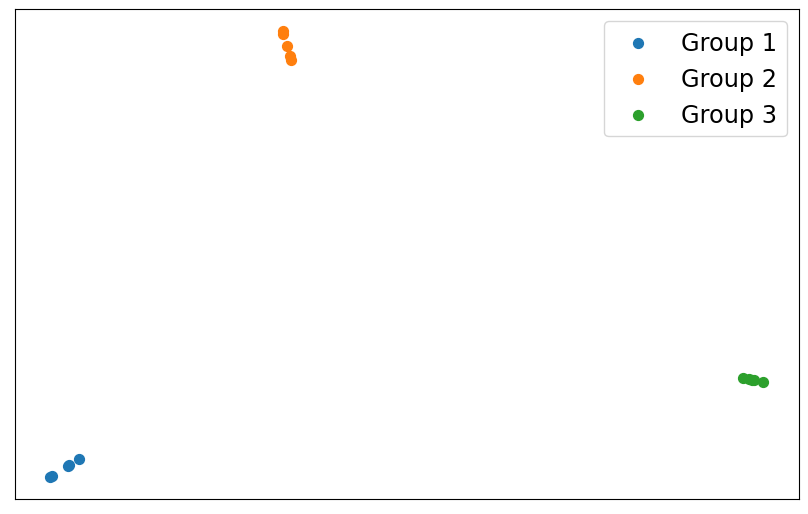

15
predicted_labels: [2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8666906952857971, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.967, [0.993, 0.94, 0.967], 0.185
FedDF: 0.502, [0.8, 0.273, 0.433], 0.239
DS_FL: 0.551, [0.867, 0.307, 0.48], 0.349
sever idcs: 100
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 100
Global Logit's Accuracy: 67.00%
acc before distill: 0.889, [0.933, 0.873, 0.86], 0.269
[2 2 2 2 2 1 1 1 1 1 0 0 0 0 0]


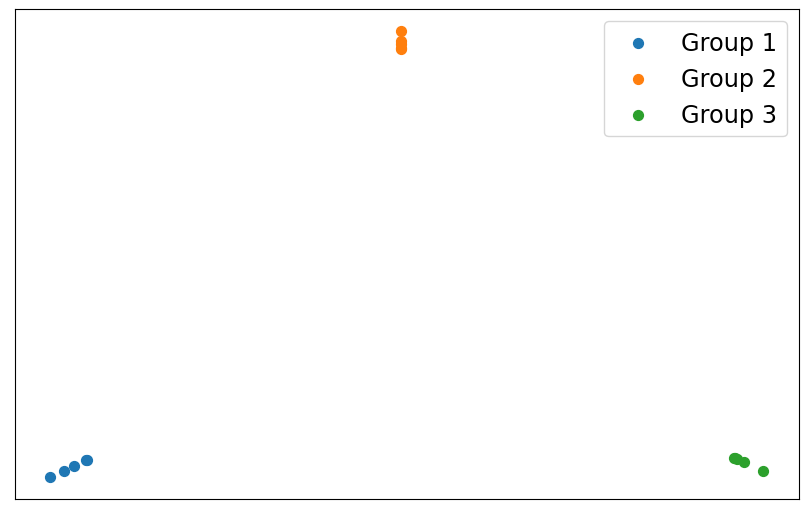

15
predicted_labels: [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.790594220161438, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.947, [0.953, 0.953, 0.933], 0.278
FedDF: 0.58, [0.633, 0.513, 0.593], 0.362
DS_FL: 0.669, [0.733, 0.6, 0.673], 0.669
sever idcs: 100
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 100
Global Logit's Accuracy: 63.00%
acc before distill: 0.864, [0.887, 0.86, 0.847], 0.361
[1 1 1 1 1 0 0 0 0 0 2 2 2 2 2]


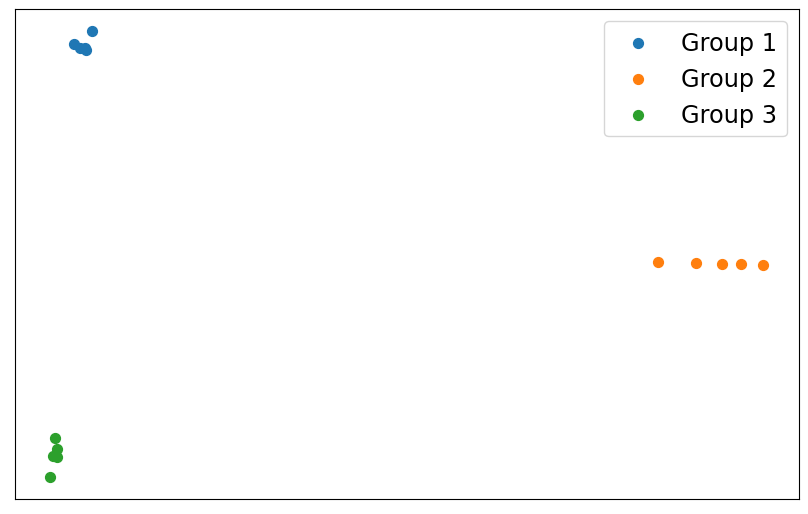

15
predicted_labels: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.7657958269119263, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.9, [0.9, 0.92, 0.88], 0.371
FedDF: 0.513, [0.587, 0.247, 0.707], 0.339
DS_FL: 0.624, [0.74, 0.4, 0.733], 0.625
sever idcs: 100
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 100
Global Logit's Accuracy: 58.00%
acc before distill: 0.853, [0.913, 0.827, 0.82], 0.426
[1 1 1 1 1 0 0 0 0 0 2 2 2 2 2]


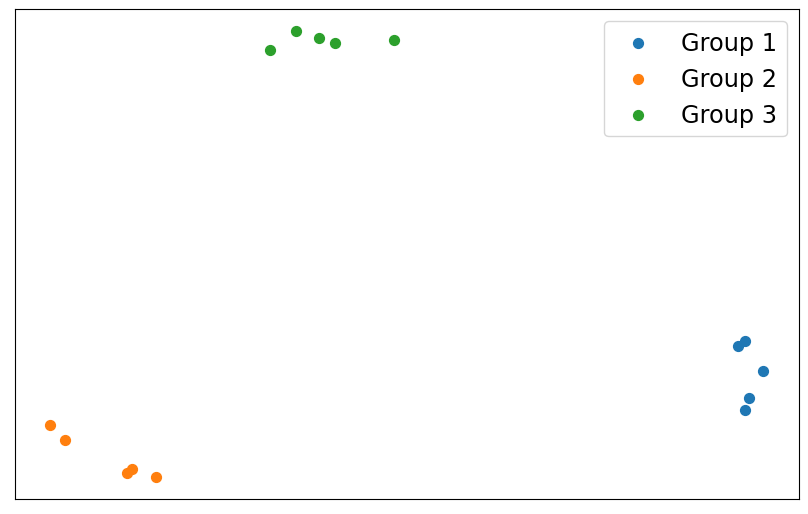

15
predicted_labels: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.7647445201873779, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.889, [0.94, 0.88, 0.847], 0.457
FedDF: 0.567, [0.707, 0.4, 0.593], 0.426
DS_FL: 0.678, [0.847, 0.493, 0.693], 0.603
sever idcs: 300
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 300
Global Logit's Accuracy: 36.33%
acc before distill: 0.949, [0.98, 0.953, 0.913], 0.318
[2 2 2 2 2 1 1 1 1 1 0 0 0 0 0]


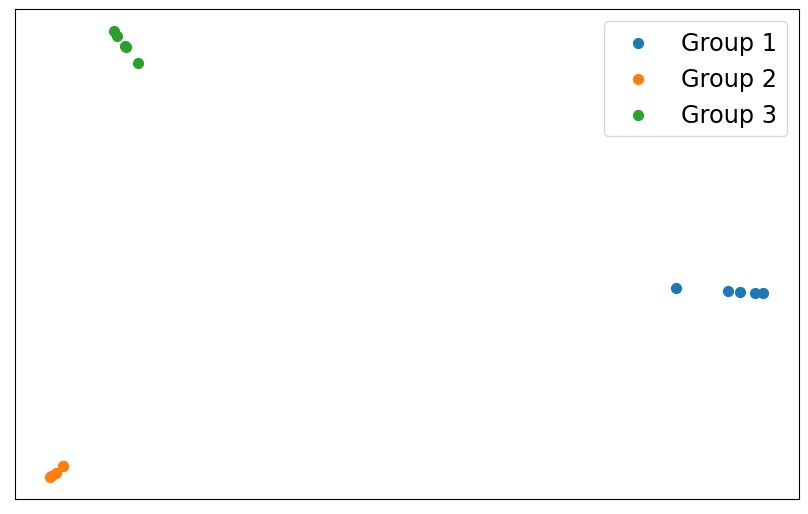

15
predicted_labels: [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.7600260376930237, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.971, [0.987, 0.96, 0.967], 0.317
FedDF: 0.636, [0.947, 0.667, 0.293], 0.706
DS_FL: 0.616, [0.98, 0.667, 0.2], 0.765
sever idcs: 300
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 300
Global Logit's Accuracy: 61.00%
acc before distill: 0.9, [0.933, 0.847, 0.92], 0.316
[2 2 2 2 2 0 0 0 0 0 1 1 1 1 1]


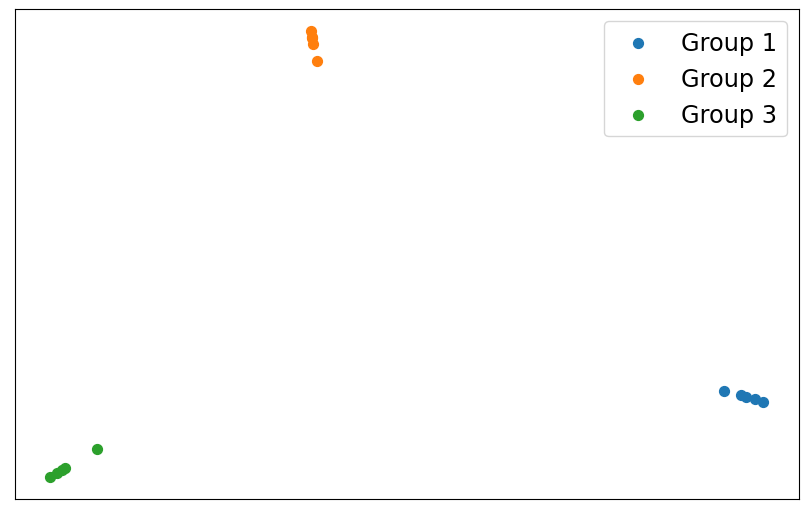

15
predicted_labels: [2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.7879804372787476, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.929, [0.94, 0.92, 0.927], 0.321
FedDF: 0.627, [0.807, 0.393, 0.68], 0.61
DS_FL: 0.644, [0.873, 0.347, 0.713], 0.709
sever idcs: 300
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 300
Global Logit's Accuracy: 60.00%
acc before distill: 0.856, [0.887, 0.84, 0.84], 0.434
[1 1 1 1 1 0 0 0 0 0 2 2 2 2 2]


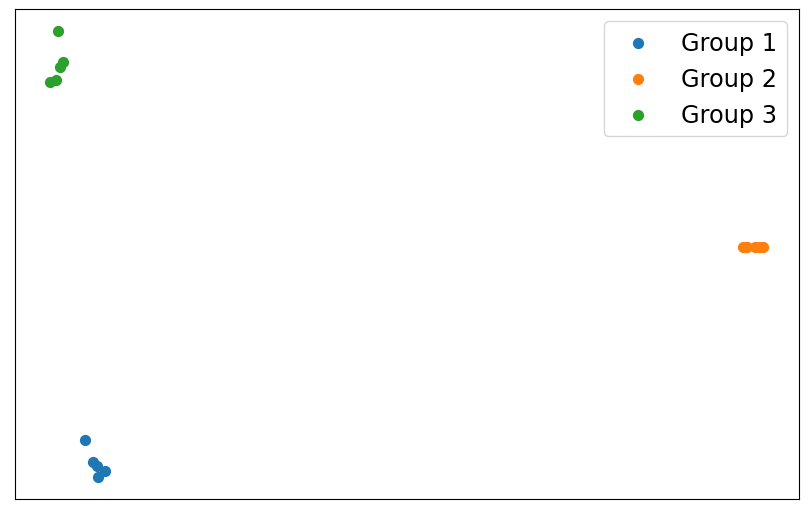

15
predicted_labels: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.7408913969993591, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.913, [0.92, 0.933, 0.887], 0.446
FedDF: 0.587, [0.66, 0.347, 0.753], 0.628
DS_FL: 0.638, [0.693, 0.413, 0.807], 0.756
sever idcs: 300
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 300
Global Logit's Accuracy: 57.00%
acc before distill: 0.867, [0.913, 0.86, 0.827], 0.508
[2 2 2 2 2 1 1 1 1 1 0 0 0 0 0]


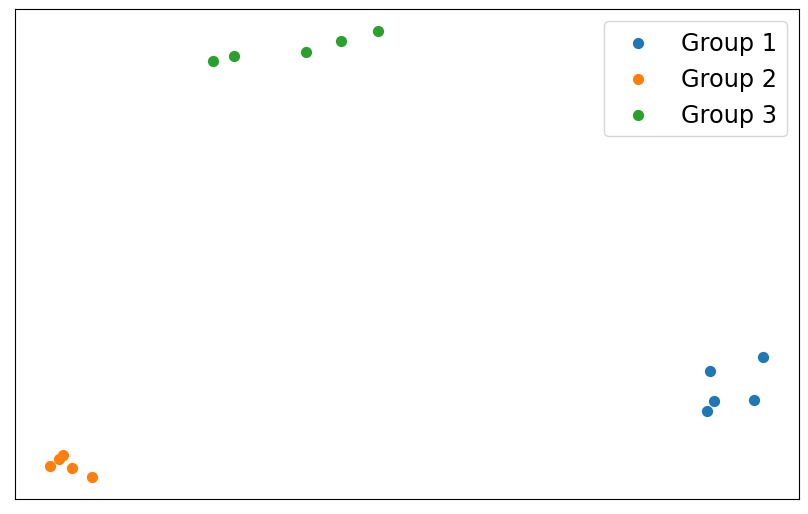

15
predicted_labels: [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.7707753777503967, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.896, [0.94, 0.887, 0.86], 0.54
FedDF: 0.66, [0.8, 0.473, 0.707], 0.749
DS_FL: 0.693, [0.853, 0.493, 0.733], 0.802
sever idcs: 500
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 500
Global Logit's Accuracy: 35.80%
acc before distill: 0.967, [0.993, 0.94, 0.967], 0.325
[2 2 2 2 2 0 0 0 0 0 1 1 1 1 1]


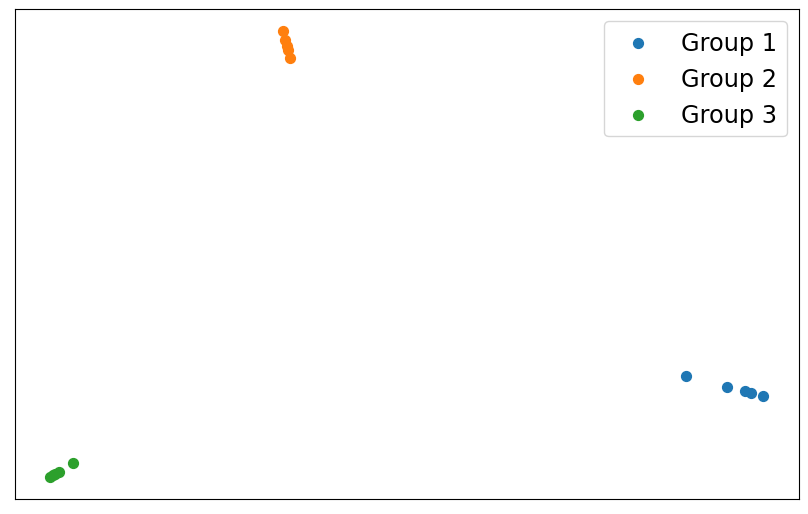

15
predicted_labels: [2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.815001904964447, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.971, [0.993, 0.947, 0.973], 0.327
FedDF: 0.538, [0.9, 0.473, 0.24], 0.855
DS_FL: 0.58, [0.96, 0.52, 0.26], 0.888
sever idcs: 500
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 500
Global Logit's Accuracy: 63.80%
acc before distill: 0.891, [0.953, 0.853, 0.867], 0.319
[1 1 1 1 1 0 0 0 0 0 2 2 2 2 2]


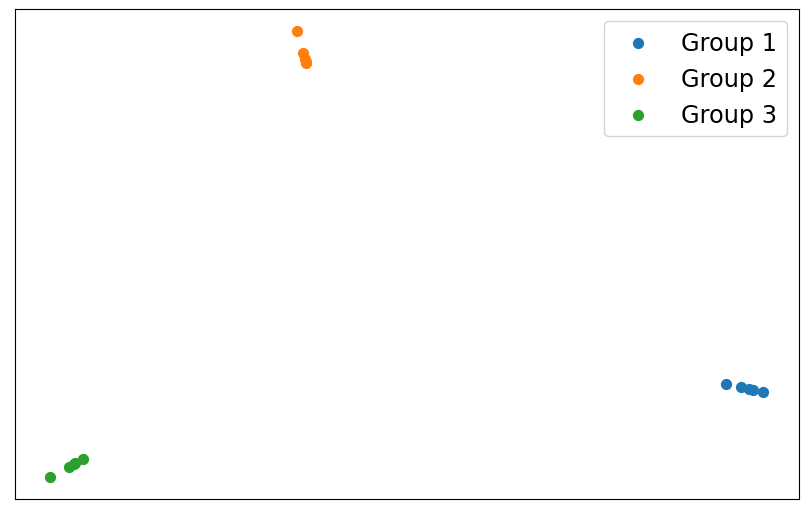

15
predicted_labels: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8023574352264404, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.92, [0.953, 0.927, 0.88], 0.326
FedDF: 0.6, [0.787, 0.38, 0.633], 0.818
DS_FL: 0.678, [0.873, 0.467, 0.693], 0.882
sever idcs: 500
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 500
Global Logit's Accuracy: 52.20%
acc before distill: 0.862, [0.9, 0.827, 0.86], 0.548
[1 1 1 1 1 0 0 0 0 0 2 2 2 2 2]


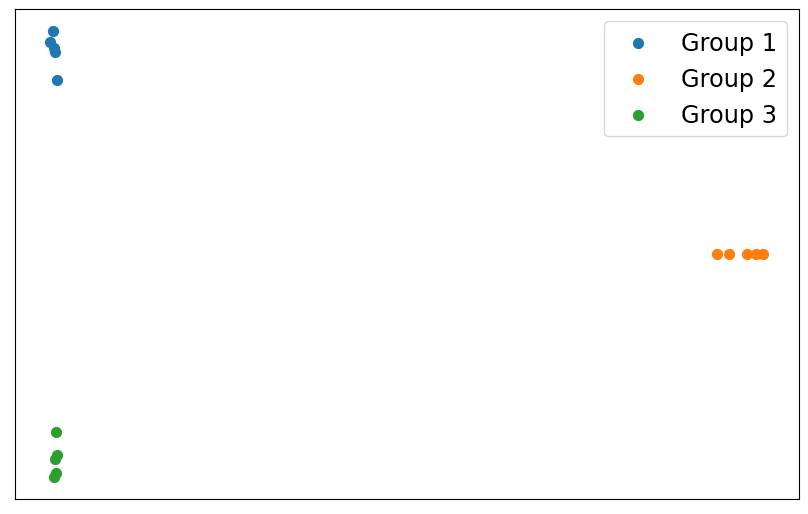

15
predicted_labels: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.7914174795150757, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.904, [0.927, 0.913, 0.873], 0.556
FedDF: 0.562, [0.753, 0.273, 0.66], 0.912
DS_FL: 0.611, [0.84, 0.32, 0.673], 0.936
sever idcs: 500
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 500
Global Logit's Accuracy: 57.20%
acc before distill: 0.86, [0.92, 0.813, 0.847], 0.596
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]


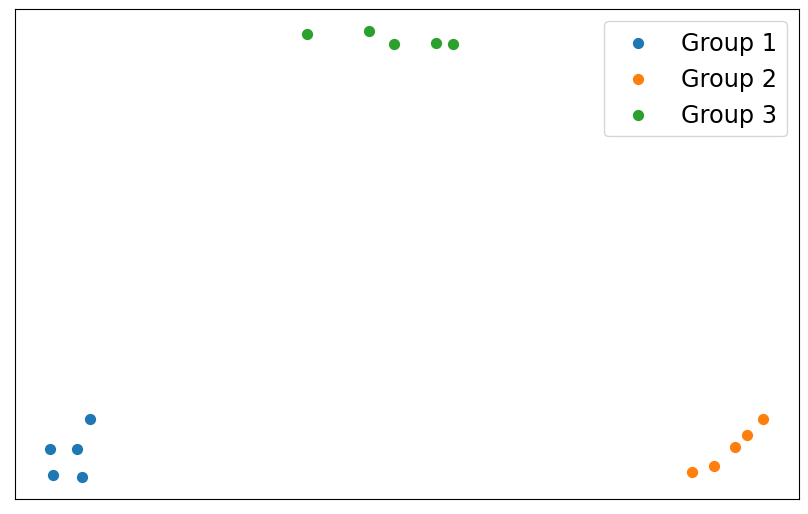

15
predicted_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.7762386202812195, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.893, [0.92, 0.867, 0.893], 0.619
FedDF: 0.642, [0.76, 0.42, 0.747], 0.934
DS_FL: 0.68, [0.82, 0.48, 0.74], 0.926
sever idcs: 1000
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 1000
Global Logit's Accuracy: 35.50%
acc before distill: 0.958, [0.987, 0.953, 0.933], 0.327
[0 0 0 0 0 2 2 2 2 2 1 1 1 1 1]


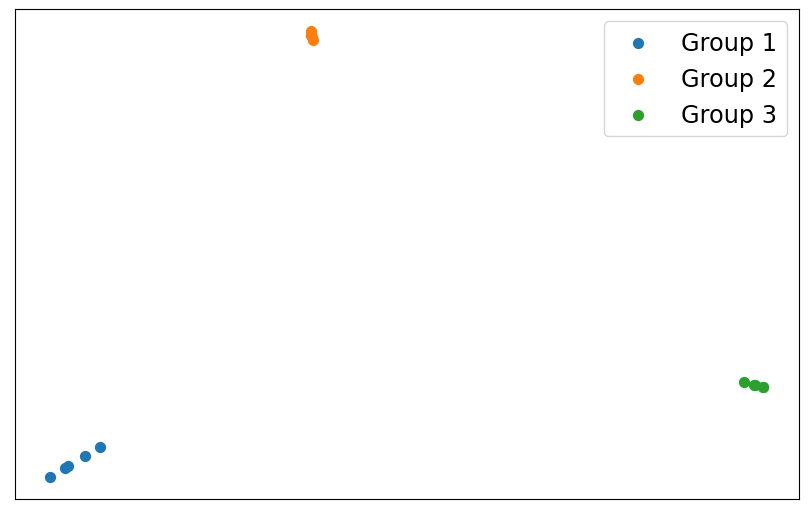

15
predicted_labels: [0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8807128667831421, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.969, [0.987, 0.973, 0.947], 0.329
FedDF: 0.544, [0.9, 0.413, 0.32], 0.861
DS_FL: 0.582, [0.933, 0.413, 0.4], 0.898
sever idcs: 1000
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 1000
Global Logit's Accuracy: 63.40%
acc before distill: 0.916, [0.933, 0.88, 0.933], 0.321
[2 2 2 2 2 0 0 0 0 0 1 1 1 1 1]


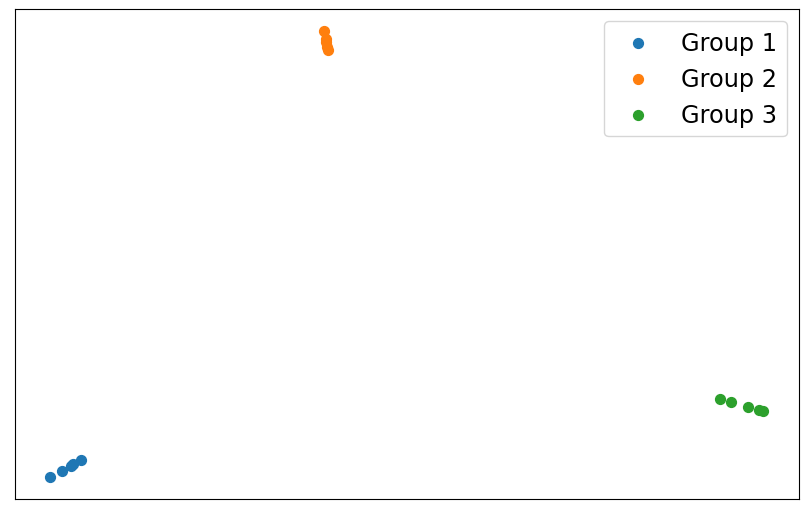

15
predicted_labels: [2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8075993657112122, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.924, [0.94, 0.92, 0.913], 0.324
FedDF: 0.667, [0.867, 0.453, 0.68], 0.915
DS_FL: 0.691, [0.913, 0.5, 0.66], 0.938
sever idcs: 1000
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 1000
Global Logit's Accuracy: 52.50%
acc before distill: 0.833, [0.887, 0.76, 0.853], 0.555
[0 0 0 0 0 3 1 1 1 1 2 2 2 2 2]


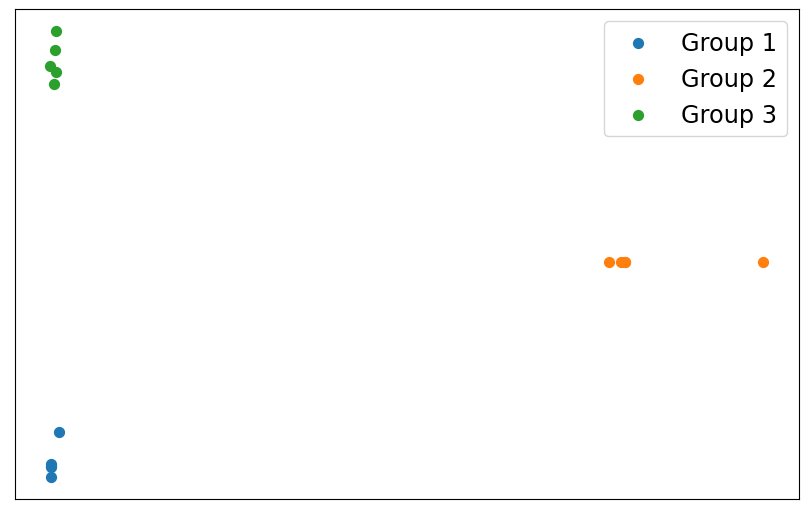

15
predicted_labels: [0, 0, 0, 0, 0, 3, 1, 1, 1, 1, 2, 2, 2, 2, 2]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.7731863856315613, ari: 0.9027777777777778
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.853, [0.913, 0.767, 0.88], 0.567
FedDF: 0.553, [0.753, 0.193, 0.713], 0.89
DS_FL: 0.644, [0.807, 0.32, 0.807], 0.911
sever idcs: 1000
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 1000
Global Logit's Accuracy: 59.10%
acc before distill: 0.871, [0.927, 0.84, 0.847], 0.605
[2 2 2 2 2 1 1 1 1 1 0 0 0 0 0]


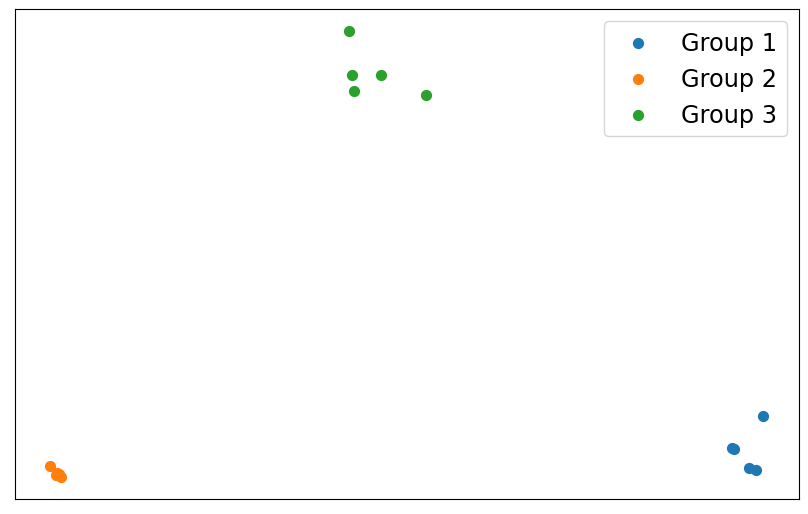

15
predicted_labels: [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8219760060310364, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.9, [0.94, 0.88, 0.88], 0.632
FedDF: 0.673, [0.82, 0.507, 0.693], 0.908
DS_FL: 0.7, [0.847, 0.56, 0.693], 0.901
sever idcs: 100
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 100
Global Logit's Accuracy: 42.00%
acc before distill: 0.974, [0.989, 0.962, 0.971], 0.188
[2 2 2 2 2 0 0 0 0 0 1 1 1 1 1]


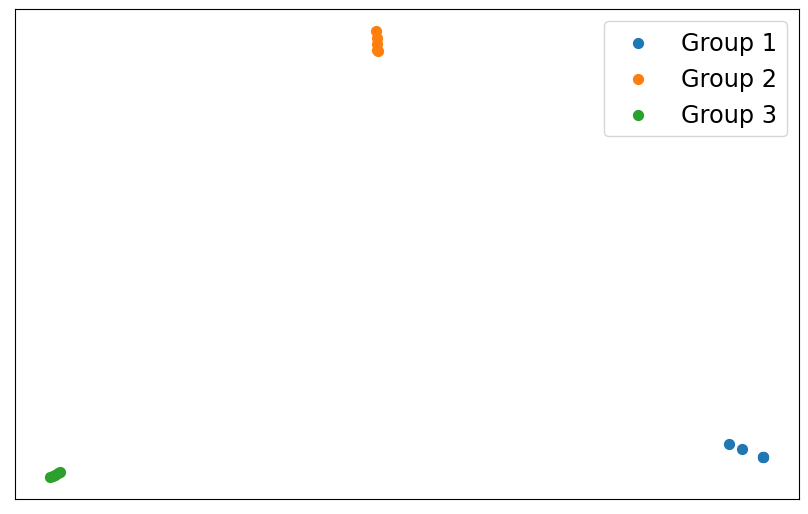

15
predicted_labels: [2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.9126278758049011, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.973, [0.991, 0.956, 0.971], 0.187
FedDF: 0.555, [0.733, 0.409, 0.522], 0.231
DS_FL: 0.604, [0.729, 0.442, 0.64], 0.36
sever idcs: 100
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 100
Global Logit's Accuracy: 71.00%
acc before distill: 0.958, [0.978, 0.936, 0.96], 0.283
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]


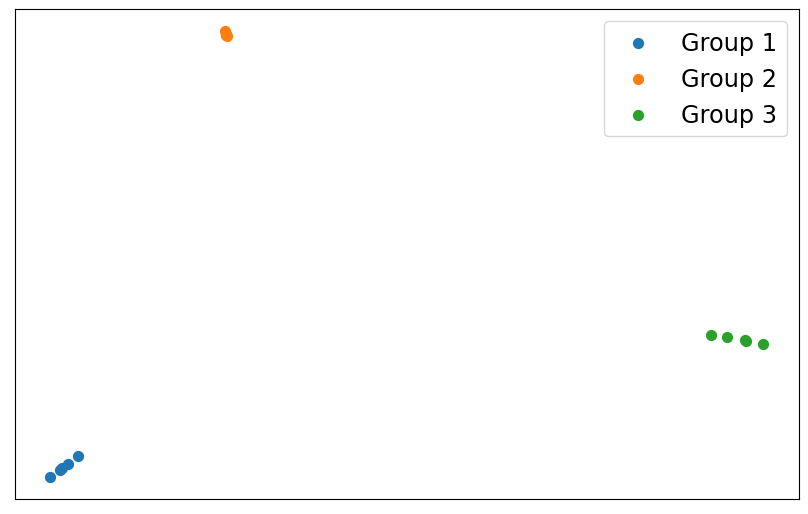

15
predicted_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8684645891189575, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.965, [0.973, 0.947, 0.976], 0.28
FedDF: 0.596, [0.487, 0.573, 0.727], 0.411
DS_FL: 0.63, [0.598, 0.591, 0.702], 0.675
sever idcs: 100
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 100
Global Logit's Accuracy: 74.00%
acc before distill: 0.941, [0.942, 0.94, 0.94], 0.376
[2 2 2 2 2 1 1 1 1 1 0 0 0 0 0]


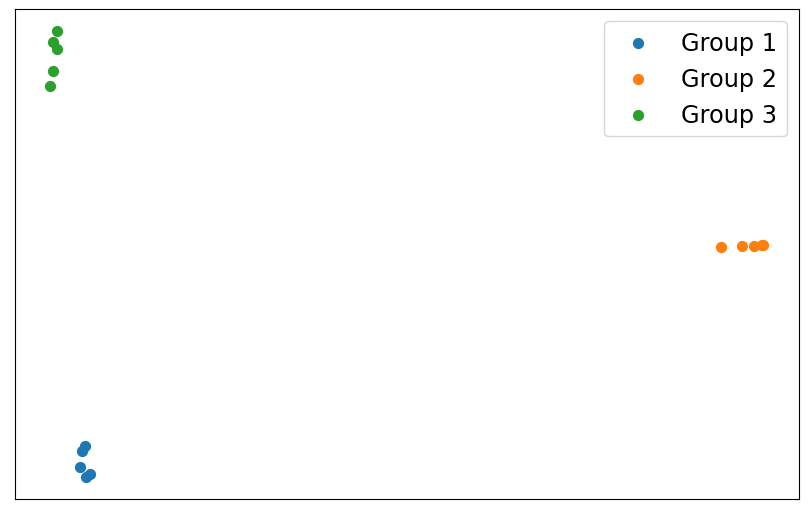

15
predicted_labels: [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8436434268951416, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.946, [0.953, 0.951, 0.933], 0.38
FedDF: 0.626, [0.704, 0.393, 0.78], 0.472
DS_FL: 0.683, [0.724, 0.564, 0.76], 0.728
sever idcs: 100
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 100
Global Logit's Accuracy: 59.00%
acc before distill: 0.927, [0.942, 0.924, 0.916], 0.456
[2 2 2 2 2 1 1 1 1 1 0 0 0 0 0]


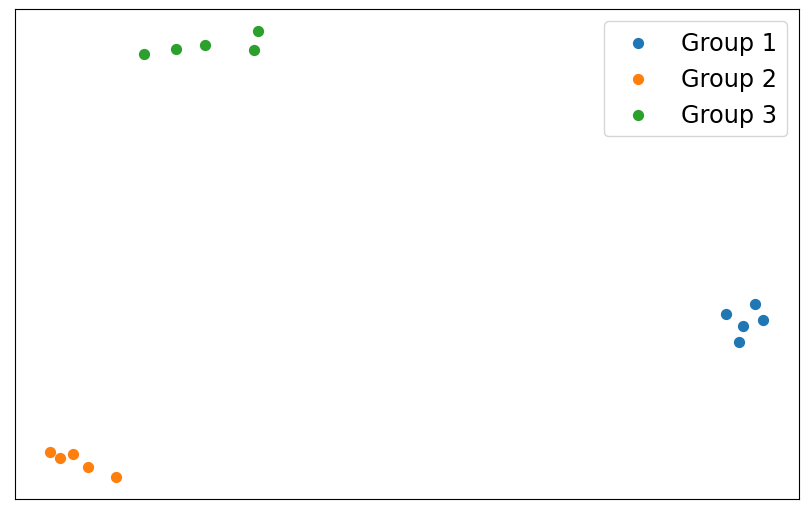

15
predicted_labels: [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8377545475959778, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.935, [0.947, 0.942, 0.916], 0.465
FedDF: 0.635, [0.771, 0.44, 0.693], 0.483
DS_FL: 0.722, [0.822, 0.598, 0.747], 0.641
sever idcs: 300
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 300
Global Logit's Accuracy: 42.33%
acc before distill: 0.967, [0.987, 0.956, 0.96], 0.318
[0 0 0 0 0 2 2 2 2 2 1 1 1 1 1]


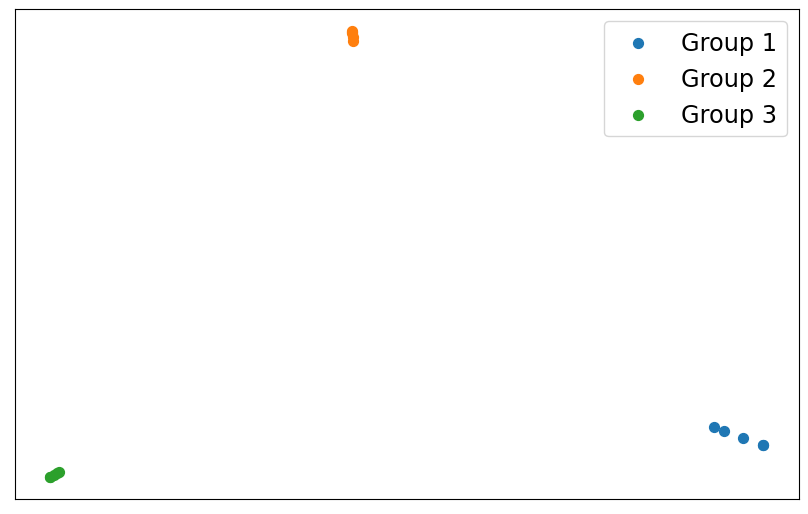

15
predicted_labels: [0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.9210352301597595, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.969, [0.996, 0.944, 0.967], 0.323
FedDF: 0.533, [0.658, 0.422, 0.518], 0.563
DS_FL: 0.528, [0.658, 0.413, 0.513], 0.635
sever idcs: 300
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 300
Global Logit's Accuracy: 70.00%
acc before distill: 0.954, [0.969, 0.936, 0.958], 0.32
[2 2 2 2 2 1 1 1 1 1 0 0 0 0 0]


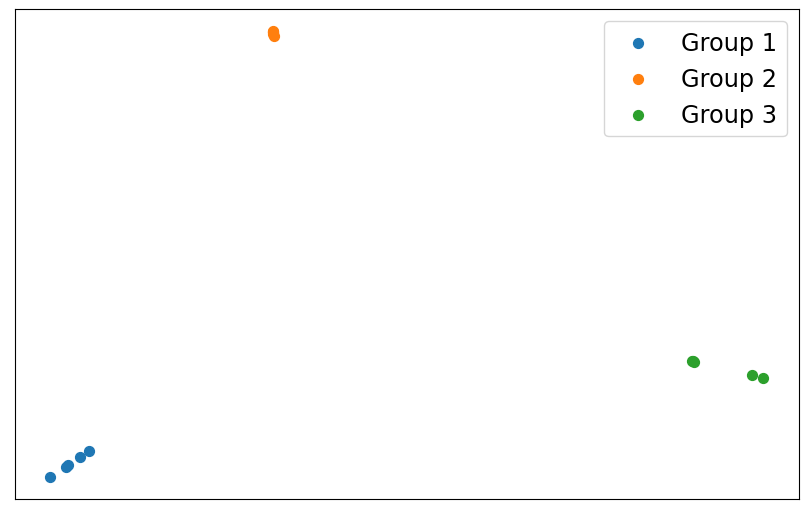

15
predicted_labels: [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8218905329704285, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.965, [0.971, 0.956, 0.969], 0.32
FedDF: 0.633, [0.607, 0.613, 0.68], 0.554
DS_FL: 0.652, [0.682, 0.6, 0.673], 0.752
sever idcs: 300
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 300
Global Logit's Accuracy: 67.33%
acc before distill: 0.944, [0.951, 0.936, 0.947], 0.453
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]


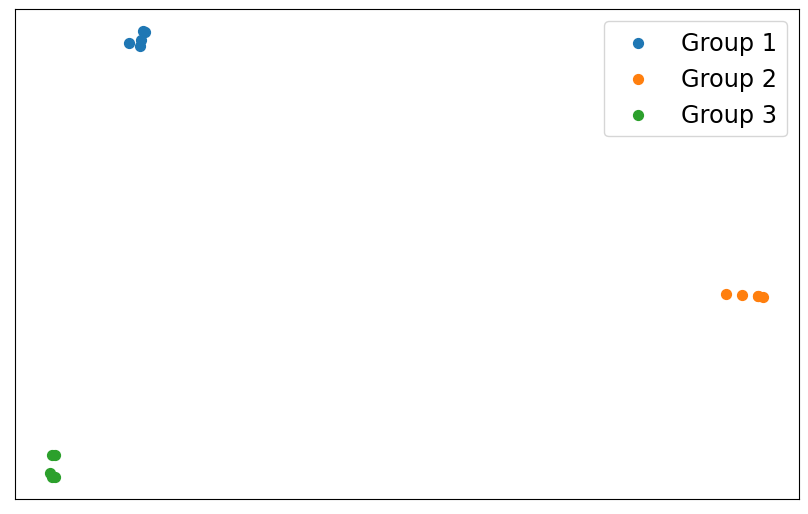

15
predicted_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8692384362220764, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.941, [0.956, 0.947, 0.922], 0.458
FedDF: 0.625, [0.722, 0.351, 0.802], 0.695
DS_FL: 0.688, [0.749, 0.502, 0.813], 0.797
sever idcs: 300
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 300
Global Logit's Accuracy: 58.00%
acc before distill: 0.922, [0.942, 0.909, 0.916], 0.535
[2 2 2 2 2 1 1 1 1 1 0 0 0 0 0]


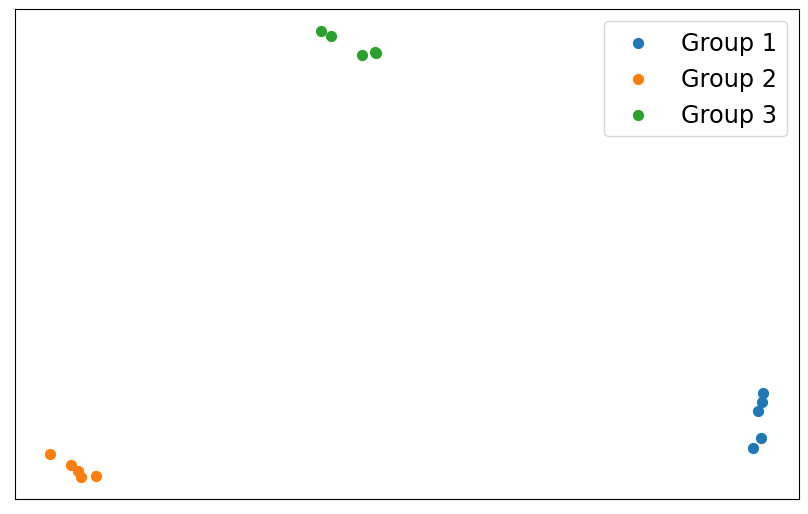

15
predicted_labels: [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8685721755027771, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.934, [0.956, 0.92, 0.927], 0.539
FedDF: 0.671, [0.769, 0.504, 0.74], 0.714
DS_FL: 0.716, [0.811, 0.589, 0.749], 0.752
sever idcs: 500
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 500
Global Logit's Accuracy: 43.80%
acc before distill: 0.975, [0.989, 0.96, 0.976], 0.329
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]


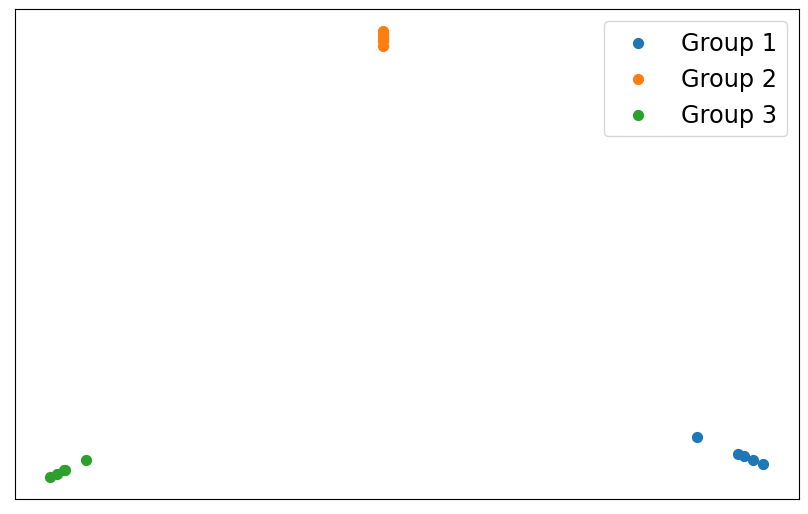

15
predicted_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8793264031410217, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Ours: 0.978, [0.993, 0.96, 0.98], 0.331
FedDF: 0.58, [0.751, 0.433, 0.556], 0.712
DS_FL: 0.601, [0.713, 0.491, 0.598], 0.774
sever idcs: 500
num_groups: 3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
test_data: 500
Global Logit's Accuracy: 68.80%
acc before distill: 0.956, [0.971, 0.936, 0.962], 0.321
[0 0 0 0 0 2 2 2 2 2 1 1 1 1 1]


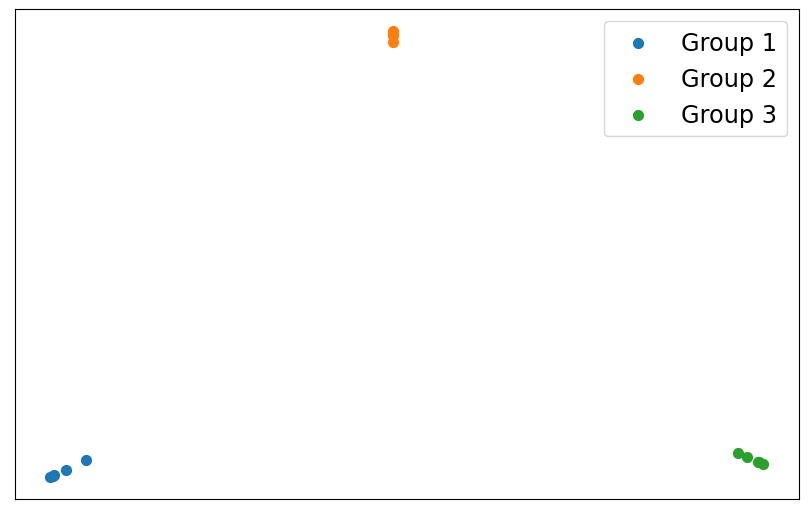

15
predicted_labels: [0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8833582401275635, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill


In [ ]:
import pandas as pd

t = 2

# Initialize an empty list to store all results
all_results = []

# Define only one group count, which is 3
group_count = 3

# Update cluster_distribution based on new group_count
cluster_distribution = [1/group_count for i in range(1, group_count+1)]

# Initialize n_clients based on group_count
n_clients = group_count * 5

# Loop over the different data_per_client values: 100, 300, and 500
for data_per_client in [50, 100, 300, 500]:
    # Loop over the different public_dataset_size values: 500 and 1000
    for public_dataset_size in [100, 300, 500, 1000]:
        # Loop over the range of 'class_per_group' values
        for class_per_group in range(2, 6):  # Values 2, 3, 4, 5
            # Assuming you have a function to get instances_per_class_per_client
            instances_per_class_per_client = get_combination(group_count, class_per_group)

            # Run the experiment
            client_accs, cluster_accs, global_accs, silhouette, ari = cluster_train_result_exp(
                n_clients, 40000, public_dataset_size, group_count, cluster_distribution, 
                data_per_client//class_per_group, 0, instances_per_class_per_client, t
            )

            # Append to the list as a dictionary
            all_results.append({
                'group_count': group_count,
                'class_per_group': class_per_group,
                'client_accs': client_accs,
                'cluster_accs': cluster_accs,
                'global_accs': global_accs,
                'silhouette': silhouette,
                'ari': ari,
                'data_per_client': data_per_client,
                'public_dataset_size': public_dataset_size
            })

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(all_results)


In [ ]:
df

### Minor class Exp

In [ ]:
# import pandas as pd

# # Initialize empty DataFrame to store results with simplified columns
# minor_class_ratios = [5, 20, 30, 40, 50]
# cluster_distribution = [1/3, 1/3, 1/3]
# clustering_acc = pd.DataFrame(columns=['silhouette', 'ari'], index=minor_class_ratios)
# # client_acc = pd.DataFrame(columns=['before_distill', 'global_distill', 'cluster_distill'], index=minor_class_ratios)
# # cluster_acc = pd.DataFrame(columns=['before_distill', 'global_distill', 'cluster_distill'], index=minor_class_ratios)

# cluster_count = 3
# t = 2

# # instance_per_classes = [158, 150, 133, 117, 100, 84]
# # instance_per_minor_classes = [4, 7, 14, 21, 29, 36]
# instance_per_classes = [158, 133, 117, 100, 84]
# instance_per_minor_classes = [4, 14, 21, 29, 36]
# # Iterate over different minor_class_ratios, instance_per_classes, and instance_per_minor_classes values
# for minor_class_ratio, instance_per_class, instance_per_minor_class in zip(minor_class_ratios, instance_per_classes, instance_per_minor_classes):
#     n_clients = cluster_count * 10
#     instances_per_class_per_client = get_combination(cluster_count, 3)
    
#     # Replace with your actual clustering_exp function
#     # Assume it accepts t as a parameter
#     client_accs, cluster_accs, global_accs, silhouette, ari = cluster_train_result_exp(
#             n_clients, 40000, 4000, cluster_count, cluster_distribution, instance_per_class, instance_per_minor_class, instances_per_class_per_client, t
#     )
    
#     # Update DataFrame
#     clustering_acc.loc[minor_class_ratio, 'silhouette'] = silhouette
#     clustering_acc.loc[minor_class_ratio, 'ari'] = ari
    
# #     client_acc.loc[minor_class_ratio, 'before_distill'] = client_accs[0]
# #     client_acc.loc[minor_class_ratio, 'cluster_distill'] = client_accs[1]
# #     client_acc.loc[minor_class_ratio, 'global_distill'] = client_accs[2]
    
# #     cluster_acc.loc[minor_class_ratio, 'before_distill'] = cluster_accs[0]
# #     cluster_acc.loc[minor_class_ratio, 'cluster_distill'] = cluster_accs[1]
# #     cluster_acc.loc[minor_class_ratio, 'global_distill'] = cluster_accs[2]

In [ ]:
clustering_acc

In [ ]:
client_acc

In [ ]:
cluster_acc